# Machine learning application: Forecasting wind power. 

### Using alternative energy for social & enviromental Good

<table>
  <tr><td>
    <img src="https://github.com/dmatrix/mlflow-workshop-part-3/raw/master/images/wind_farm.jpg"
         alt="Keras NN Model as Logistic regression"  width="800">
  </td></tr>
</table>

In this notebook, we will use the MLflow Model Registry to build a machine learning application that forecasts the daily power output of a [wind farm](https://en.wikipedia.org/wiki/Wind_farm). 

Wind farm power output depends on weather conditions: generally, more energy is produced at higher wind speeds. Accordingly, the machine learning models used in the notebook predict power output based on weather forecasts with three features: `wind direction`, `wind speed`, and `air temperature`.

* This notebook uses altered data from the [National WIND Toolkit dataset](https://www.nrel.gov/grid/wind-toolkit.html) provided by NREL, which is publicly available and cited as follows:*

* Draxl, C., B.M. Hodge, A. Clifton, and J. McCaa. 2015. Overview and Meteorological Validation of the Wind Integration National Dataset Toolkit (Technical Report, NREL/TP-5000-61740). Golden, CO: National Renewable Energy Laboratory.*

* Draxl, C., B.M. Hodge, A. Clifton, and J. McCaa. 2015. "The Wind Integration National Dataset (WIND) Toolkit." Applied Energy 151: 355366.*

* Lieberman-Cribbin, W., C. Draxl, and A. Clifton. 2014. Guide to Using the WIND Toolkit Validation Code (Technical Report, NREL/TP-5000-62595). Golden, CO: National Renewable Energy Laboratory.*

* King, J., A. Clifton, and B.M. Hodge. 2014. Validation of Power Output for the WIND Toolkit (Technical Report, NREL/TP-5D00-61714). Golden, CO: National Renewable Energy Laboratory.*

Googl's Deep publised a [AI for Social Good: 7 Inspiring Examples](https://www.springboard.com/blog/ai-for-good/) blog. One of example was
how Wind Farms can predict expected power ouput based on wind conditions and temperature, hence mitigating the burden from consuming
energy from fossil fuels. 

<table>
  <tr><td>
    <img src="https://github.com/dmatrix/ds4g-workshop/raw/master/notebooks/images/deepmind_system-windpower.gif"
         alt="Deep Mind ML Wind Power"  width="400">
    <img src="https://github.com/dmatrix/ds4g-workshop/raw/master/notebooks/images/machine_learning-value_wind_energy.max-1000x1000.png"
         alt="Deep Mind ML Wind Power"  width="400">
  </td></tr>
</table>


### Classes and Utility functions

In [1]:
!pip install mlflow
!pip install scikit-learn

     |████████████████████████████████| 13.9MB 284kB/s 
     |████████████████████████████████| 153kB 46.6MB/s 
     |████████████████████████████████| 6.0MB 46.9MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 1.1MB 44.0MB/s 
     |████████████████████████████████| 163kB 46.3MB/s 
     |████████████████████████████████| 327kB 42.9MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 204kB 49.7MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 92kB 10.1MB/s 
     |████████████████████████████████| 2.6MB 44.1MB/s 
     |████████████████████████████████| 122kB 44.3MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.13-cp36-cp36m-linux_x86_64.whl size=1217160 sha256=76cd391ae0903e2ef9cd6da82ec5f7b23d8b77247905d7375475dec1af42f6f

In [2]:
import pandas as pd
import time
import warnings
import mlflow
from mlflow.tracking.client import MlflowClient
from mlflow.entities.model_registry.model_version_status import ModelVersionStatus
warnings.filterwarnings("ignore")
print("Using mlflow version {}".format(mlflow.__version__))

Using mlflow version 1.11.0


In [3]:
class Utils:
  @staticmethod
  def load_data(path, index_col=0):
    df = pd.read_csv(path,index_col=0)
    return df
  
  @staticmethod
  def get_training_data(df):
    # From 2014 through 2018 and drop the power column since that
    # is our dependent variable
    
    training_data = pd.DataFrame(df["2014-01-01":"2018-01-01"])
    X = training_data.drop(columns="power")
    
    # Get our dependent variable values
    y = training_data["power"]
    return X, y

  @staticmethod
  def get_validation_data(df):
    # From 2018 through 2019 and drop the power column since that
    # our dependent variable
    
    validation_data = pd.DataFrame(df["2018-01-01":"2019-01-01"])
    X = validation_data.drop(columns="power")
    
    # Get our dependent variable values
    y = validation_data["power"]
    return X, y

### Define our model and utility classes 

This allows us to use some Python model classes and utility functions

In [4]:
import mlflow.sklearn
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [5]:
class RFRModel():
   def __init__(self, params={}):
      self.rf = RandomForestRegressor(**params)
      self.params = params
      self._mse = None
      self._rsme = None

   @classmethod
   def new_instance(cls, params={}):
      return cls(params)

   @property
   def model(self):
      return self.rf

   @property
   def mse(self):
      return self._mse

   @mse.setter
   def mse(self, value):
      self._mse = value

   @property
   def rsme(self):
      return self._rsme

   @rsme.setter
   def rsme(self, value):
      self._rsme = value

   def mlflow_run(self, X_train, y_train, val_x, val_y, model_name,
                  run_name="Random Forest Regressor: Power Forecasting Model",
                  register=False, verbose=False):
      with mlflow.start_run(run_name=run_name) as run:
         # Log all parameters
         mlflow.log_params(self.params)

         # Train and fit the model
         self.rf.fit(X_train, y_train)
         y_pred = self.rf.predict(val_x)

         # Compute metrics
         self._mse = mean_squared_error(y_pred, val_y)
         self._rsme = np.sqrt(self._mse)

         if verbose:
            print("Validation MSE: %d" % self._mse)
            print("Validation RMSE: %d" % self._rsme)

         # log params and metrics
         mlflow.log_params(self.params)
         mlflow.log_metric("mse", self._mse)
         mlflow.log_metric("rmse", self._rsme)

         # Specify the `registered_model_name` parameter of the
         # function to register the model with the Model Registry. This automatically
         # creates a new model version for each new run
         mlflow.sklearn.log_model(
            sk_model=self.model,
            artifact_path="sklearn-model",
            registered_model_name=model_name) if register else mlflow.sklearn.log_model(
               sk_model=self.model,
               artifact_path="sklearn-model")

         run_id = run.info.run_id

      return run_id

### Load our training data

In [6]:
csv_path = "https://raw.githubusercontent.com/dmatrix/ds4g-workshop/master/notebooks/data/windfarm_data.csv"
wind_farm_data = Utils.load_data(csv_path, index_col=0)
wind_farm_data.head(5)

,temperature_00,wind_direction_00,wind_speed_00,temperature_08,wind_direction_08,wind_speed_08,temperature_16,wind_direction_16,wind_speed_16,power
2014-01-01,4.702022,106.742590,4.743292,7.189482,100.41638,6.593832,8.172301,99.28800,5.967206,1959.3535
2014-01-02,7.695733,98.036705,6.142715,9.977118,94.03181,4.383676,9.690135,204.25444,1.696528,1266.6239
2014-01-03,9.608235,274.061200,10.514304,10.840864,242.87563,16.869741,8.991079,250.26830,12.038399,7545.6797
2014-01-04,6.955563,257.910220,7.189170,5.317223,254.26170,9.069233,3.021174,284.06537,4.590843,3791.0408
2014-01-05,0.830547,265.394400,4.263086,2.480239,104.79496,3.042063,4.227131,263.41690,3.899182,880.6115


In [11]:
X_train, y_train = Utils.get_training_data(wind_farm_data)
val_x, val_y = Utils.get_validation_data(wind_farm_data)

### Initialize a set of hyperparameters for the training and try three runs

In [9]:
# Initialize our model hyperparameters
params_list = [{"n_estimators": 100},
               {"n_estimators": 200},
               {"n_estimators": 300}]

In [12]:
# Train, fit and register our model and iterate over few different tuning parameters
# Use sqlite:///mlruns.db as the local store for tracking and registery

mlflow.set_tracking_uri("sqlite:///mlruns.db")

model_name = "PowerForecastingModel"
for params in params_list:
  rfr = RFRModel.new_instance(params)
  print("Using paramerts={}".format(params))
  runID = rfr.mlflow_run(X_train, y_train, val_x, val_y, model_name, register=True)
  print("MLflow run_id={} completed with MSE={} and RMSE={}".format(runID, rfr.mse, rfr.rsme))

Using paramerts={'n_estimators': 100}


2020/10/02 02:52:05 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2020/10/02 02:52:05 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

MLflow run_id=e6c521ccdd1e48c0985f2857269602f1 completed with MSE=46965.93214682482 and RMSE=216.71624799914017
Using paramerts={'n_estimators': 200}


INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
Registered model 'PowerForecastingModel' already exists. Creating a new version of this model...
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
Created

MLflow run_id=1242a6d54186416b8413b6092045c375 completed with MSE=43950.928677343305 and RMSE=209.64476782725416
Using paramerts={'n_estimators': 300}


INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
Registered model 'PowerForecastingModel' already exists. Creating a new version of this model...
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
Created

MLflow run_id=50d3238bc0d645a1ac1fda301d63d381 completed with MSE=45135.735167434665 and RMSE=212.45172432210256


# Integrating Model Registry with CI/CD Forecasting Application

<table>
  <tr><td>
    <img src="https://github.com/dmatrix/mlflow-workshop-part-3/raw/master/images/forecast_app.png"
         alt="Keras NN Model as Logistic regression"  width="800">
  </td></tr>
</table>

1. Use the model registry fetch different versions of the model
2. Score the model
3. Select the best scored model
4. Promote model to production, after testing


### Let's Examine the MLflow UI

1. Let's our MLflow UI
2. Go to the link printed by `ngrok`below
 *  https://22345abcxyzz.ngrok.io
3. Let's examine some models and start comparing their metrics

In [13]:
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --backend-store-uri sqlite:///mlruns.db --port 5000 &")

In [14]:
# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6
!pip install pyngrok --quiet
from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
public_url = ngrok.connect(port="5000", proto="http", options={"bind_tls": True})
print("MLflow Tracking UI:", public_url)

MLflow Tracking UI: https://17b20a7441c5.ngrok.io


### Define a helper function to load PyFunc model from the registry
<table>
  <tr><td> Save a Keras Model Flavor and load as PyFunc Flavor</td></tr>
  <tr><td>
    <img src="https://raw.githubusercontent.com/dmatrix/mlflow-workshop-part-2/master/images/models_2.png"
         alt="" width="600">
  </td></tr>
</table>

In [15]:
def score_model(data, model_uri):
    model = mlflow.pyfunc.load_model(model_uri)
    return model.predict(data)

### Load scoring data

In [16]:
# Load the score data
score_path = "https://raw.githubusercontent.com/dmatrix/ds4g-workshop/master/notebooks/data/score_windfarm_data.csv"
score_df = Utils.load_data(score_path, index_col=0)
score_df.head()

,temperature_00,wind_direction_00,wind_speed_00,temperature_08,wind_direction_08,wind_speed_08,temperature_16,wind_direction_16,wind_speed_16,power
2020-12-27,7.123225,103.176630,8.133746,6.454002,107.793220,6.326991,7.219884,119.070526,3.062219,2621.4760
2020-12-28,5.376270,118.084330,5.558247,8.118839,116.193535,8.565966,9.307176,120.264430,11.993913,5423.6250
2020-12-29,8.593436,115.432590,12.181850,8.587968,112.931360,11.970859,8.956771,110.161095,11.301485,9132.1150
2020-12-30,8.069033,103.169685,9.983466,7.930485,106.045510,6.381556,8.228901,111.602160,4.087358,3667.9927


In [17]:
# Drop the power column since we are predicting that value
actual_power = pd.DataFrame(score_df.power.values, columns=['power'])
score = score_df.drop("power", axis=1)

In [18]:
# Formulate the model URI to fetch from the model registery
model_uri = "models:/{}/{}".format(model_name, 1)

# Predict the Power output 
pred_1 = pd.DataFrame(score_model(score, model_uri), columns=["predicted_1"])
pred_1

INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


,predicted_1
0,2812.240068
1,5117.829554
2,8759.650429
3,3780.905879


#### Combine with the actual power

In [19]:
actual_power["predicted_1"] = pred_1["predicted_1"]
actual_power

,power,predicted_1
0,2621.4760,2812.240068
1,5423.6250,5117.829554
2,9132.1150,8759.650429
3,3667.9927,3780.905879


In [20]:
# Formulate the model URI to fetch from the model registery
model_uri = "models:/{}/{}".format(model_name, 2)

# Predict the Power output
pred_2 = pd.DataFrame(score_model(score, model_uri), columns=["predicted_2"])
pred_2

INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


,predicted_2
0,2733.872546
1,5129.438811
2,8732.131560
3,3776.891900


In [21]:
actual_power["predicted_2"] = pred_2["predicted_2"]
actual_power

,power,predicted_1,predicted_2
0,2621.4760,2812.240068,2733.872546
1,5423.6250,5117.829554,5129.438811
2,9132.1150,8759.650429,8732.131560
3,3667.9927,3780.905879,3776.891900


In [22]:
# Formulate the model URI to fetch from the model registery
model_uri = "models:/{}/{}".format(model_name, 3)

# Formulate the model URI to fetch from the model registery
pred_3 = pd.DataFrame(score_model(score, model_uri), columns=["predicted_3"])
pred_3

INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


,predicted_3
0,2777.903835
1,5104.583888
2,8712.419749
3,3772.113621


### Combine the values into a single pandas DataFrame 

In [23]:
actual_power["predicted_3"] = pred_3["predicted_3"]
actual_power

,power,predicted_1,predicted_2,predicted_3
0,2621.4760,2812.240068,2733.872546,2777.903835
1,5423.6250,5117.829554,5129.438811,5104.583888
2,9132.1150,8759.650429,8732.131560,8712.419749
3,3667.9927,3780.905879,3776.891900,3772.113621


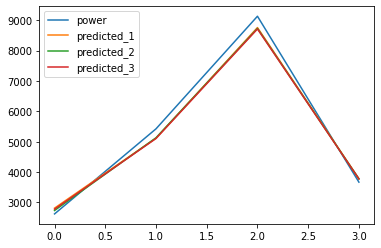

In [24]:
%matplotlib inline

actual_power.plot.line()

### Let's Examine the MLflow UI

1. Go to the link printed by `ngrok`above
 *  https://12345abcxyz.ngrok.io
2. Navigate to the Model Registry Page
3. Pick a version and transition stage: None->Production
